# Numerical solution of the Fokker-Planck Equation

In [2]:
import matplotlib.pyplot as plt
import matplotlib.animation as animation
import numpy as np

#### The Fokker Planck equation for the phase space probability distribution of the noisy harmonic oscillator reads
$$
\frac{\partial w(\xi_i,t)}{\partial t}=D_i\frac{\partial w(\xi_i,t)}{\partial\xi_i}+
D_{ij}\frac{\partial^2 w(\xi_i,t)}{\partial\xi_i\partial\xi_j}
$$
with the vector $\mathbf{\xi}=(x,v)^T$

In [344]:
# 1st derivative w.r.t. x
def dx(m):
    return m - np.roll(m, shift=1, axis=0)
# 1st derivative w.r.t. v
def dv(m):
    return m - np.roll(m, shift=1, axis=1)

#### In the case of a harmonic oscillator we have
$$
\frac{\partial w(x,v,t)}{\partial t}=v\frac{\partial w(x,v,t)}{\partial x}-
x\frac{\partial w(x,v,t)}{\partial v}-\gamma w(x,v,t) -\gamma v\frac{\partial w(x,v,t)}{\partial v}+
c\frac{\partial^2 w(x,v,t)}{\partial v^2}
$$

In [345]:
bins = 250

In [346]:
x, v = np.meshgrid(np.linspace(-1, 1, bins), np.linspace(-1, 1, bins))

In [366]:
wxv = np.zeros((bins, bins))
wxv[bins//2-25:bins//2+25, bins//2-25:bins//2+25] = 1

<IPython.core.display.Javascript object>


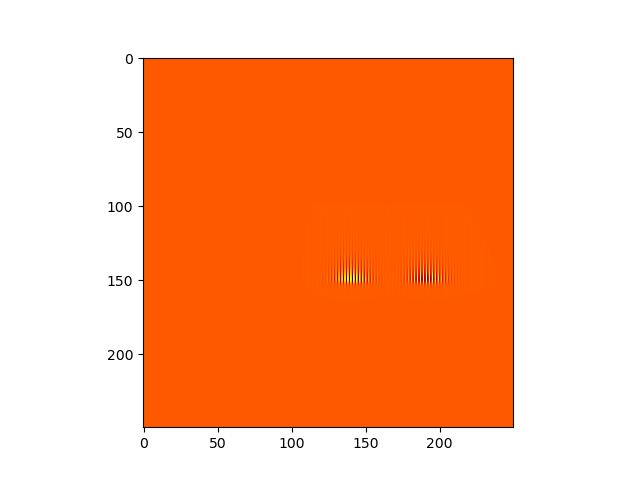

In [367]:
%matplotlib notebook
dt = .001

gamma = 1
k = 1
t = 1
m = 1

for i in np.arange(10000):
    wxv[2:-2, 2:-2] = (wxv + (- dx(v * wxv) + dv(wxv * (gamma * v + 0)) + (gamma * k * t / m) * dv(dv(wxv))) * dt)[2:-2, 2:-2]

plt.imshow(wxv, cmap='hot')
plt.show()